In [2]:
import casadi
from casadi import *
import numpy
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
rc('animation', html='jshtml')
from ipywidgets import IntProgress

In [3]:
g = 9.8
m = 30000 
min_thrust = 338e3 
max_thrust = 845e3 

#The length is taken from the current Falcon 9 Spacecraft 
length = 69 # m 
width = 3.7

# Inertia for a uniform density rod 
I = (1/12) * m * length**2

deg_to_rad = 0.01745329

max_gimble = 20  * deg_to_rad
min_gimble = -max_gimble

# x[0] = x position (m)
# x[1] = x velocity (m/)
# x[2] = y position (m)
# x[3] = y velocity (m/s)
# x[4] = angle (rad)
# x[5] = angular velocity (rad/s)


# u[0] = thrust (percent)
# u[1] = thrust angle (rad)


#thrust angle here is the gimbal angle 
def x_dot(x, u):
    theta = x[4]
    
    thrust = u[0]
    thrust_angle = u[1]
    
    # Horizontal force
    F_x = max_thrust * thrust * sin(thrust_angle + theta)
    x_dot = x[1]
    x_dotdot = (F_x) / m
        
    # Vertical force
    F_y = max_thrust * thrust * cos(thrust_angle + theta)
    y_dot = x[3]
    y_dotdot = (F_y) / m - g
    
    # Torque
    T = -length/2 * max_thrust * thrust * sin(thrust_angle)
    theta_dot = x[5]
    theta_dotdot = T / I
    
    return casadi.vertcat(x_dot, x_dotdot, y_dot, y_dotdot, theta_dot, theta_dotdot)

In [4]:
# Make an optimization problem
opti = casadi.Opti()

# Set the number of steps and the timestep (dt)
steps = 400
t_step = 0.04

# Generate the array of state and control vectors
x = opti.variable(steps, 6)
u = opti.variable(steps, 2)

#Trapezoidal transctiption for the cost function 
def L(x,u):
    return u[0]**2 + u[1]**2 

#Continous cost approximation with Trapezoidal Rule 
J=0
for i in range(steps-1):
    J += 0.5 * t_step * ( L(x[i,:], u[i,:]) + L(x[i+1,:], u[i+1,:]) )

#Adding Penalty on the final state 
J+= sumsqr(x[-1,:])

#Initial and final conditions of the rocket 
x[0, :] = [0, 0, 1000, -110, -np.pi/2, 0]
x[steps-1, :] = [0, 0, 0, 0, 0, 0]


# Cost function
opti.minimize(J)

# Set dynamics constraints
for i in range(0, steps-1):
    xdot_i   = x_dot(x[i, :],   u[i, :])
    xdot_ip1 = x_dot(x[i+1, :], u[i+1, :])
    
    # Trapezoidal collocation scheme 
    opti.subject_to( (x[i+1, :] - x[i, :]).T == 0.5 * t_step * (xdot_i + xdot_ip1) )

# Set control bounds constraints
for i in range(0, steps):
    opti.subject_to( opti.bounded(0.4, u[i, 0], 1))
    opti.subject_to( opti.bounded(min_gimble, u[i, 1], max_gimble))

# Select solver
opti.solver('ipopt', {}, {'max_iter': 90000})

# Solve!
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13544
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:     2400

Total number of variables............................:     3200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2394
Total number of inequality c

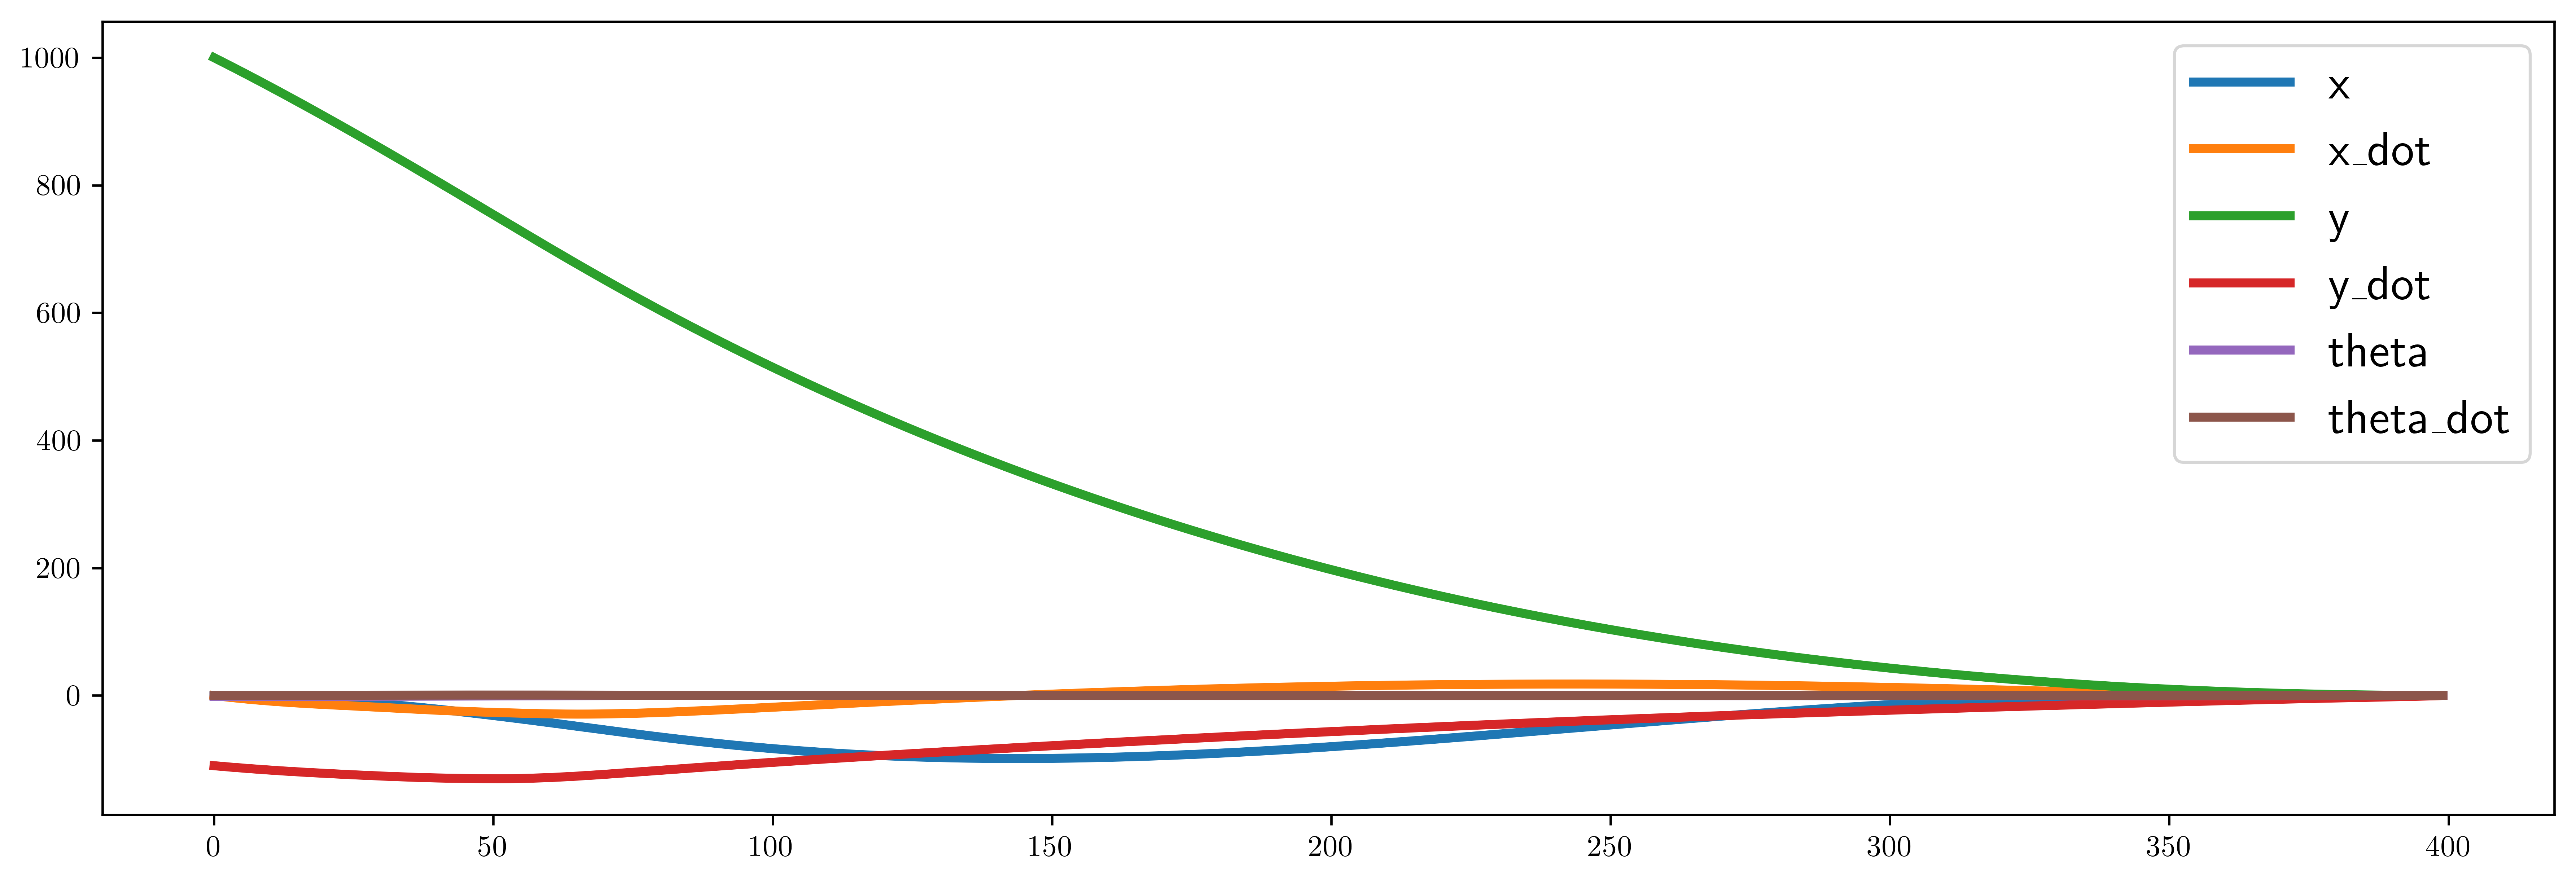

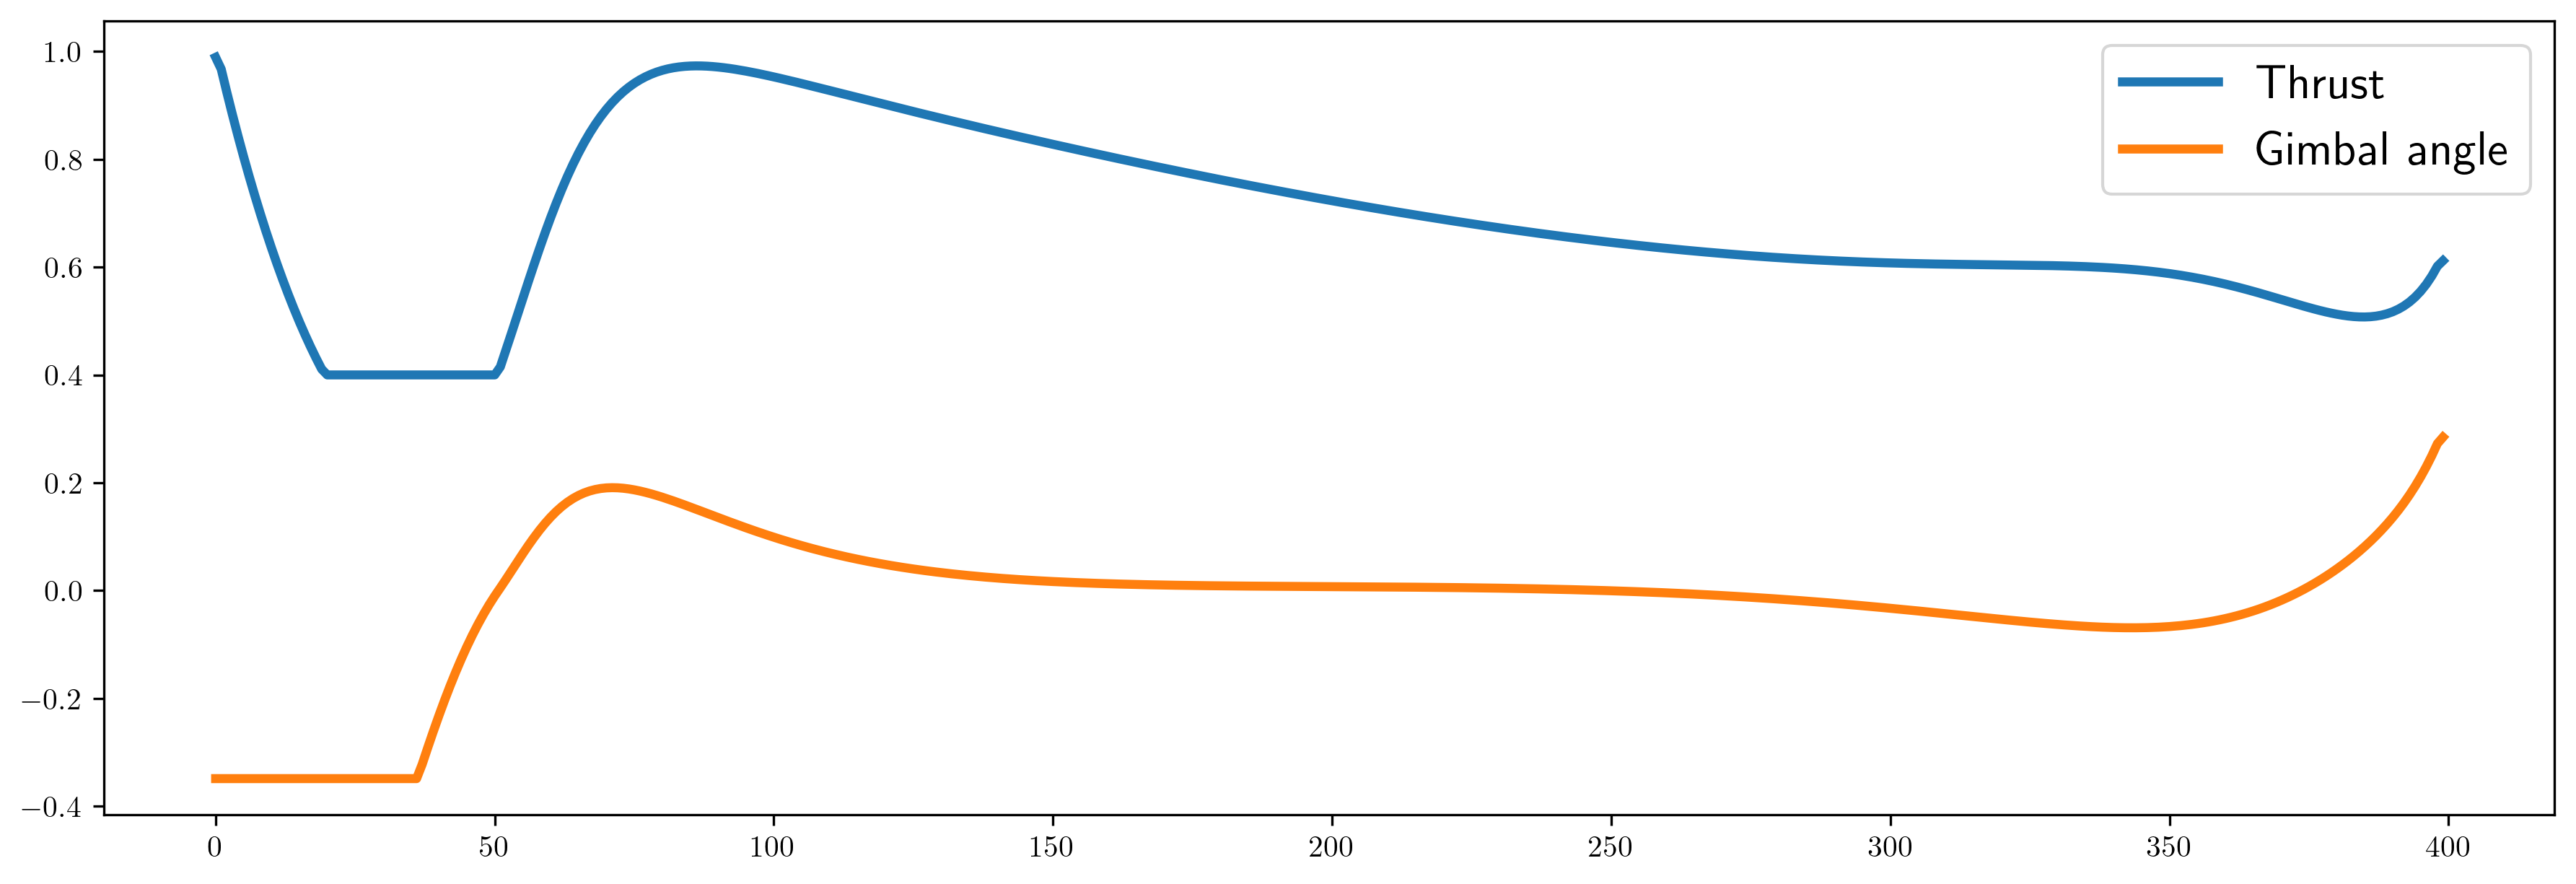

0.04
16.0


In [5]:
# Plot state
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(12,8), dpi=600)
plt.subplot(211)
plt.plot(sol.value(x)[:, 0], label = "x",linewidth=3)
plt.plot(sol.value(x)[:, 1], label = "x_dot",linewidth=3)
plt.plot(sol.value(x)[:, 2], label = "y",linewidth=3)
plt.plot(sol.value(x)[:, 3], label = "y_dot",linewidth=3)
plt.plot(sol.value(x)[:, 4], label = "theta",linewidth=3)
plt.plot(sol.value(x)[:, 5], label = "theta_dot",linewidth=3)
plt.tight_layout()
plt.legend(fontsize=16)
plt.show()

# Plot control input
plt.figure(figsize=(12,8),dpi=300)
plt.subplot(212)
plt.plot(sol.value(u)[:, 0], label = "Thrust %" , linewidth=3)
plt.plot(sol.value(u)[:, 1], label = "Gimbal angle", linewidth=3)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

final_time_step = sol.value(t_step);
duration = sol.value(t_step) * steps

print(sol.value(t_step))
print(sol.value(t_step * steps))

Generating Animation


IntProgress(value=0, max=400)

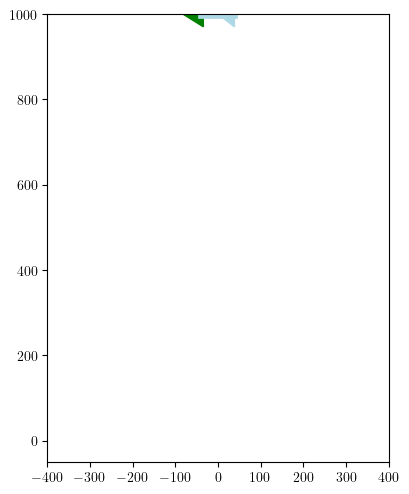

In [6]:
from matplotlib.patches import Polygon
print("Generating Animation")
f = IntProgress(min = 0, max = steps)
display(f)

x_t = sol.value(x)
u_t = sol.value(u)

fig = plt.figure(figsize = (5, 5), constrained_layout=False)

ax1 = fig.add_subplot(111)

ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange')
ln2, = ax1.plot([], [], linewidth = 2, color = 'tomato')
ln1, = ax1.plot([], [], linewidth = 7, color = 'lightblue')

# Add rocket tip (triangular cap)
rocket_tip = Polygon([[0,0],[50,60],[-50,60]], closed=True, color='green')
rocket_tip = Polygon([[0,0],[60,80],[-60,80]], closed=True, color='green')
ax1.add_patch(rocket_tip)
rocket_fin = Polygon([[0,0],[100,200],[-100,200]], closed=True, color='lightblue')
rocket_fin = Polygon([[0,0],[70,140],[-70,140]], closed=True, color='lightblue')
ax1.add_patch(rocket_fin)

#plt.axis('off')
plt.tight_layout()

ax1.set_xlim(-400, 400)
ax1.set_ylim(-50, 1000)
ax1.set_aspect(1)


def update(i):
  rocket_theta = x_t[i, 4]

  rocket_x = x_t[i, 0]
  rocket_x_points = [rocket_x + length/2 * sin(rocket_theta), rocket_x - length/2 * sin(rocket_theta)]

  rocket_y = x_t[i, 2]
  rocket_y_points = [rocket_y + length/2 * cos(rocket_theta), rocket_y - length/2 * cos(rocket_theta)]

  ln1.set_data(rocket_x_points, rocket_y_points)


  thrust_mag = u_t[i, 0]
  thrust_angle = -u_t[i, 1]

  flame_length = (thrust_mag) * 50


  flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * sin(thrust_angle - rocket_theta)]
  flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * cos(thrust_angle - rocket_theta)]

  ln2.set_data(flame_x_points, flame_y_points)

  ln6.set_data(x_t[:i, 0], x_t[:i, 2])

  # Update rocket tip and fins (triangles)
  tip_shape = np.array([
    [0, 1.2*length],   # top point
    [30, 0.5*length],          # right base
    [-30, 0.5*length]          # left base 
    ])

  fin_shape = np.array([
    [-1, -1],        # Attach point (base of rocket)
    [30, -length/1.8],     # right outer fin
    [-30, -length/1.8]     # left outer fin 
    ])


  R = np.array([
         [np.cos(rocket_theta), np.sin(rocket_theta)],
         [-np.sin(rocket_theta),  np.cos(rocket_theta)]
     ])
    
  rotated_tip = tip_shape @ R.T + np.array([rocket_x, rocket_y])
  rocket_tip.set_xy(rotated_tip)

  rotated_fin = fin_shape @ R.T + np.array([rocket_x, rocket_y])
  rocket_fin.set_xy(rotated_fin)

  f.value += 1

anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * 1000)

anim